In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from hyperopt import STATUS_OK, hp, fmin, tpe, Trials
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [2]:
# Read parquet file as dataframe
df = pd.read_parquet('bert_transformed.parquet')
df['reduced_category'] = df['reduced_category'].replace('News', 'General')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209056 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   category          209056 non-null  object
 1   text              209056 non-null  object
 2   reduced_category  209056 non-null  object
 3   embeddings        209056 non-null  object
dtypes: object(4)
memory usage: 8.0+ MB


In [3]:
# Faltten embeddings to prepare for modeling
embedding_cols = [f"embeddings_{i}" for i in range(768)] 

# Convert the embeddings to Dataframe
embedding_df = pd.DataFrame(df['embeddings'].tolist(), index=df.index, columns=embedding_cols)

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, embedding_df], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209056 entries, 0 to 209526
Columns: 772 entries, category to embeddings_767
dtypes: float32(768), object(4)
memory usage: 620.4+ MB


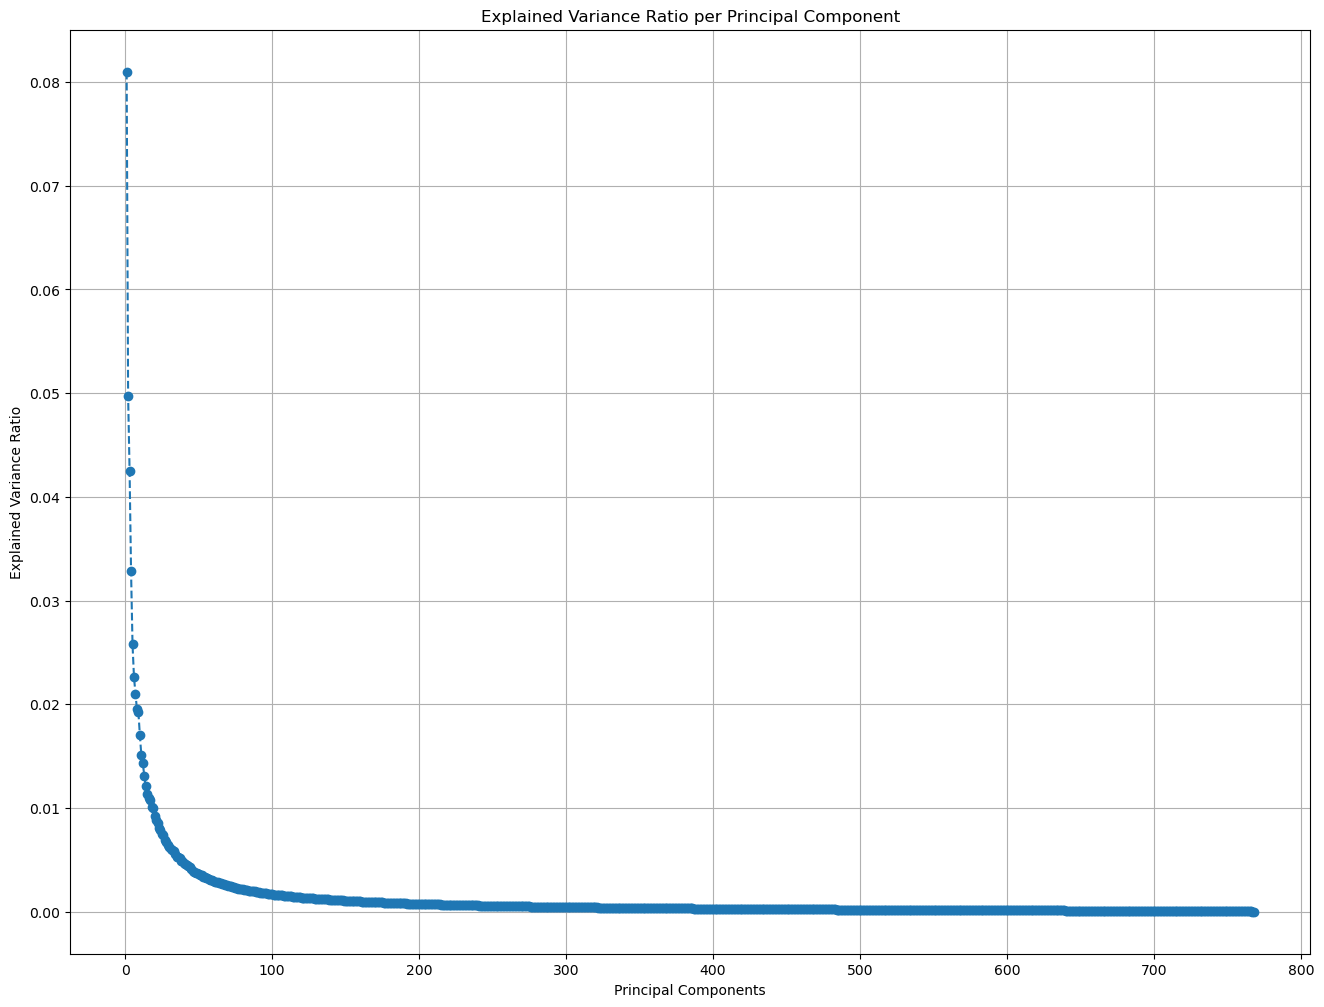

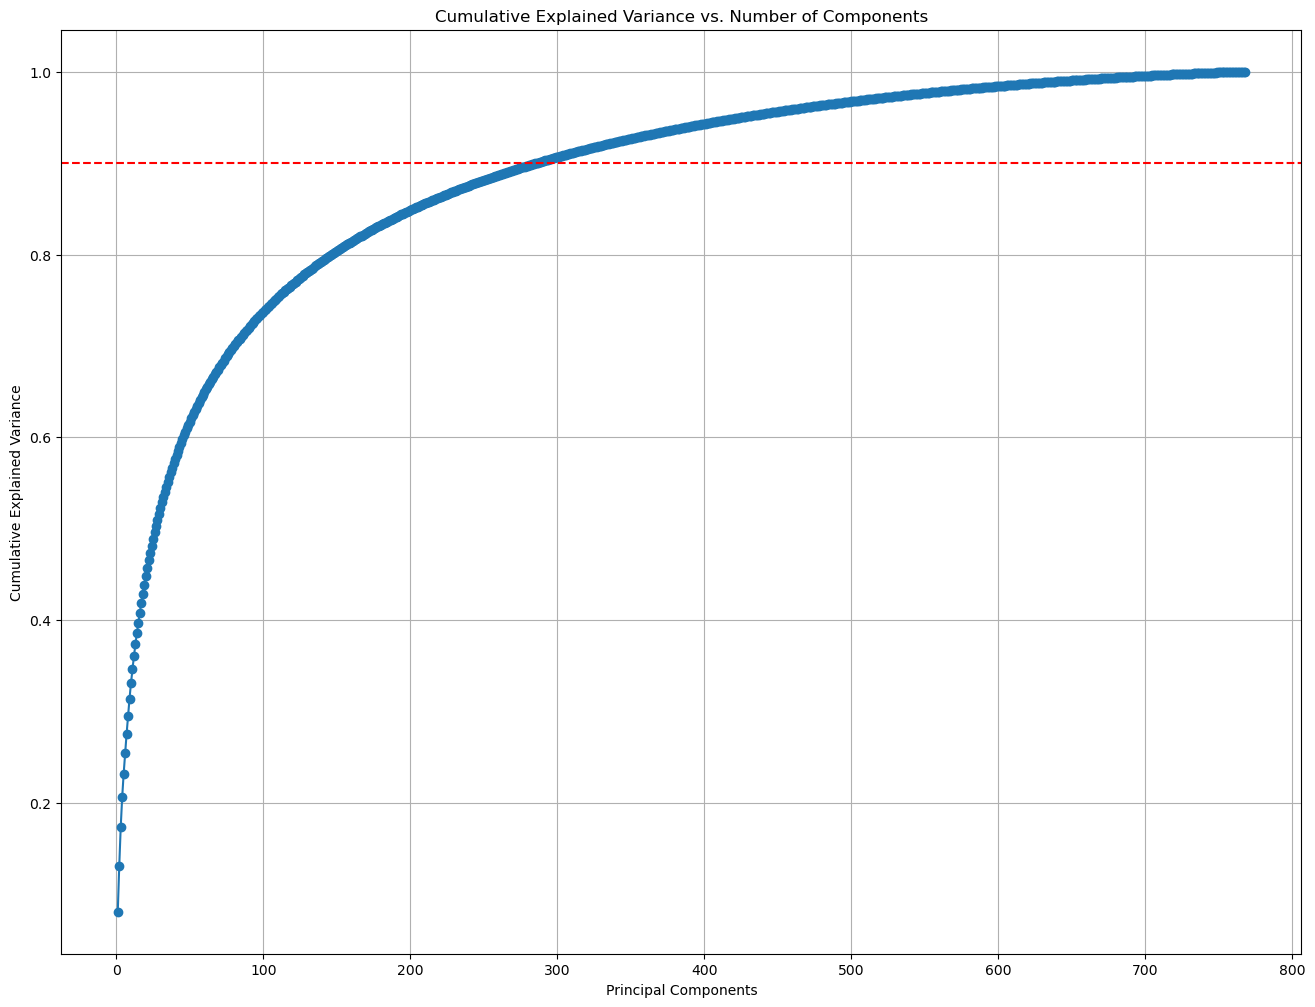

Number of components to retain 90.0% variance: 286


In [4]:
# Perform dimension reduction with PCA

# Initialize global variables
threshold = 0.9

# Transform embeddings into numpy array and scale
scaler = StandardScaler()
embeddings_matrix = scaler.fit_transform(embedding_df.values)

# Fit PCA and calculate explained variance ratio for different components
pca = PCA()
pca.fit(embeddings_matrix)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio (Elbow method)
plt.figure(figsize=(16, 12))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio per Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Step 5: Plot cumulative explained variance to identify the optimal number of components
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(16, 12))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.axhline(y=threshold, color='r', linestyle='--')  # Threshold for 95% variance
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Identify the optimal number of components
optimal_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components to retain {threshold * 100}% variance: {optimal_components}")

# Apply PCA to reduce to the optimal number of components
pca = PCA(n_components=optimal_components)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

# Create a dataframe with the reduced embeddings
reduced_embedding_cols = [f"pca_component_{i+1}" for i in range(optimal_components)]
reduced_embedding_df = pd.DataFrame(reduced_embeddings, columns=reduced_embedding_cols, index=embedding_df.index)

# Concatenate the reduced embeddings back to the original dataframe and drop the original embedding columns
df = pd.concat([df, reduced_embedding_df], axis=1)
df = df.drop(columns=embedding_cols)
df = df.drop(columns=['embeddings'])

In [5]:
# Initialize test and training dataset split
X = df.drop(columns=['category', 'reduced_category', 'text'])  # Drop the target column (labels)
y = df['reduced_category']  # The target column

In [6]:
# Initialize k-fold and dictionary to store metrics
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=32)

results = {
    'Model': [],
    'Accuracy': [],
    'Accuracy SD': [],
    'Precision': [],
    'Precision SD': [],
    'Recall': [],
    'Recall SD': [],
    'F1-Score': [],
    'F1-Score SD': [],
}

# Encode y for models that require numerical y
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [7]:
# Define metric computing functions
def compute_metrics(y_test, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    return metrics

def append_metrics(result, model_name, accuracies, precisions, recalls, f1s):
    results['Model'].append(model_name)
    results['Accuracy'].append(np.mean(accuracies))
    results['Accuracy SD'].append(np.std(accuracies))
    results['Precision'].append(np.mean(precisions))
    results['Precision SD'].append(np.std(precisions))
    results['Recall'].append(np.mean(recalls))
    results['Recall SD'].append(np.std(recalls))
    results['F1-Score'].append(np.mean(f1s))
    results['F1-Score SD'].append(np.std(f1s))

def plot_confusion_matrix(avg_cm, model_name, k):
    plt.figure(figsize=(12, 10))
    sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
    plt.title(f"Average Confusion Matrix for {model_name} ({k}-fold CV)")
    plt.xlabel("Predicted Category")
    plt.ylabel("Actual Category")
    plt.show()

In [55]:
# Logistic Regression hyperparameter search with Baysian Optimization

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Define the hyperparameter search space
space = {
    'C': hp.uniform('C', 0.1, 100) 
}

# Define the objective function for Hyperopt
def logit_objective(params):
    # Initialize Logistic Regression model with the parameters from Hyperopt
    log_reg = LogisticRegression(
        C=params['C'],  
        penalty='l2', 
        solver='lbfgs', 
        max_iter=300,
        random_state=24
    )

    # Train and fit the model
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Return the loss (negative accuracy for minimization)
    return {'loss': -accuracy, 'status': 'ok'}

# Run function
trials = Trials()
best = fmin(fn=logit_objective, 
            space=space, 
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Get the best hyperparameter 'C' found by Hyperopt
optimal_logit_c = best['C']

# Print the best hyperparameter 'C' found by Hyperopt
print(f"Optimal C: {optimal_logit_c}")

100%|████████| 50/50 [10:15<00:00, 12.31s/trial, best loss: -0.7398593705156414]
Optimal C: 74.80686823171108


Average Accuracy across 5-folds: 0.7406


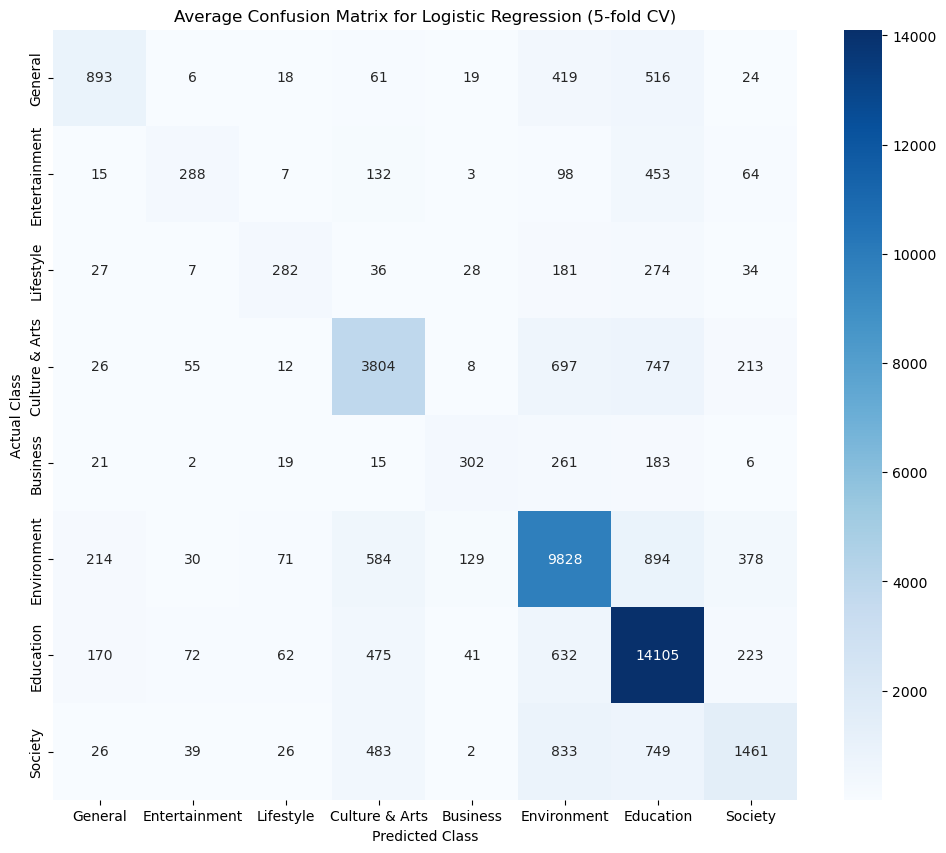

In [60]:
# Initialize hyperparameters and models
model = LogisticRegression(solver='lbfgs', penalty="l2", max_iter = 300, C=optimal_logit_c)
model_name = "Logistic Regression"

# Create lists to store metrics from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X): 
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = compute_metrics(y_test, y_pred)['accuracy']
    precision = compute_metrics(y_test, y_pred)['precision']
    recall = compute_metrics(y_test, y_pred)['recall']
    f1 = compute_metrics(y_test, y_pred)['f1']

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
append_metrics(results, model_name, accuracies, precisions, recalls, f1s)

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot confusion matrix as heatmap
plot_confusion_matrix(avg_cm, model_name, k)

In [63]:
# Linear SVC hyperparameter search with Bayesian Optimization

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# Define the search space for the hyperparameter 'C'
space = {
    'C': hp.uniform('C', 0.1, 100) 
}

# Define the objective function for hyperparameter tuning
def objective(params):
    # Initialize the LinearSVC model with the parameters from Hyperopt
    svc_model = LinearSVC(C=params['C'], max_iter=1000, random_state=24)
    
    # Train and fit the model
    svc_model.fit(X_train, y_train)
    y_pred = svc_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Return the loss (negative accuracy for minimization)
    return {'loss': -accuracy, 'status': 'ok'}

# Run function
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=50,
            trials=trials)

optimal_svc_c = best['C']

# Print the optimal hyperparameter C
print(f"Optimal C: {optimal_svc_c}")

100%|████████| 50/50 [46:48<00:00, 56.17s/trial, best loss: -0.7334736439299723]
Optimal C: 88.95540159223609


Average Accuracy across 5-folds: 0.7352


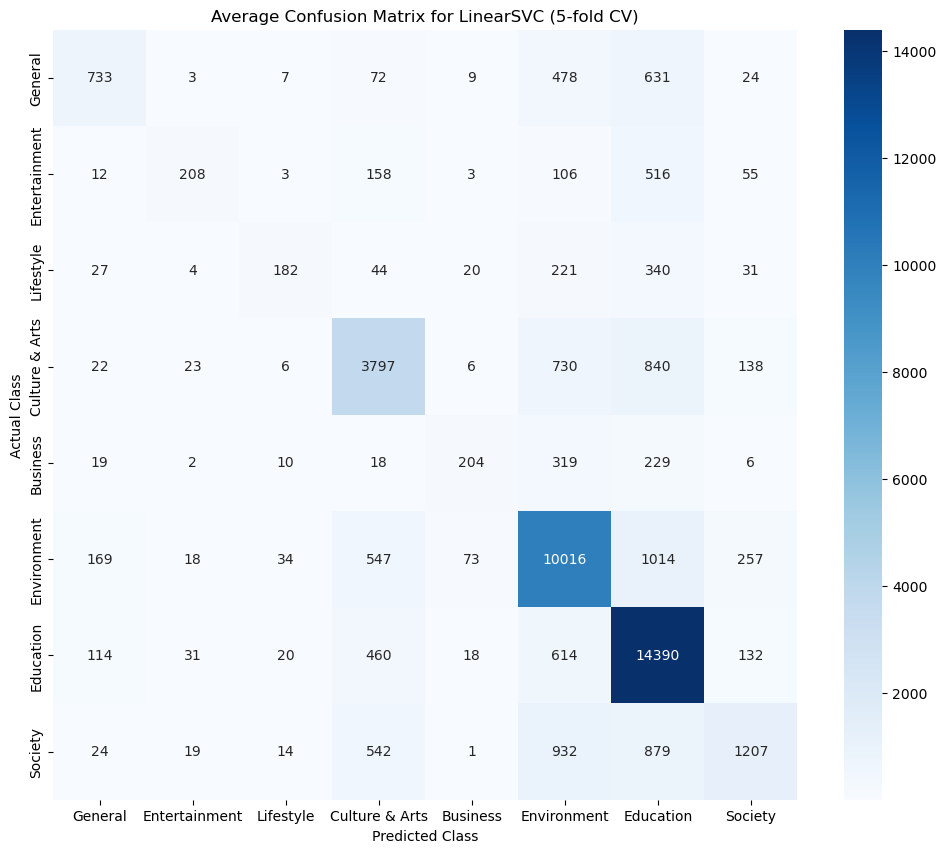

In [64]:
# Initialize hyperparameters and models
model = LinearSVC(C=optimal_svc_c, random_state=24) 
model_name = "LinearSVC"

# Create lists to store metrics from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X): 
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the scaler on the training and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fir the model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = compute_metrics(y_test, y_pred)['accuracy']
    precision = compute_metrics(y_test, y_pred)['precision']
    recall = compute_metrics(y_test, y_pred)['recall']
    f1 = compute_metrics(y_test, y_pred)['f1']

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
append_metrics(results, model_name, accuracies, precisions, recalls, f1s)

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot confusion matrix as heatmap
plot_confusion_matrix(avg_cm, model_name, k)

1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
Average Accuracy across 5-folds: 0.7444


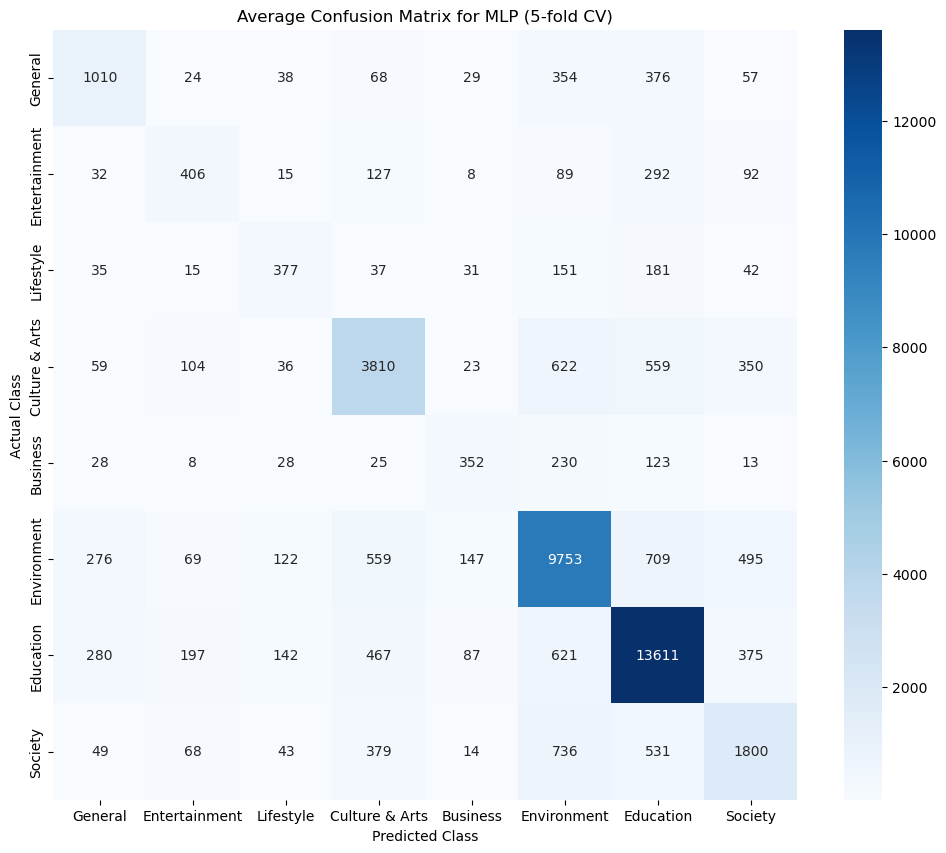

In [66]:
# Initialize hyperparameters and models

# Initialize model
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')  # 8 classes
])
model.compile(optimizer=Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model_name = "MLP"

# Create lists to store metrics from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X): 
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Train the model and predict
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

    # Calculate metrics for this fold
    metrics = compute_metrics(y_test, y_pred_classes)
    
    accuracies.append(metrics['accuracy'])
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])
    f1s.append(metrics['f1'])

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred_classes)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
append_metrics(results, model_name, accuracies, precisions, recalls, f1s)

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot Confusion Matrix as Heatmap
plot_confusion_matrix(avg_cm, model_name, k)

In [4]:
# Model comparison results
results_df = pd.DataFrame(results)
print("Overall Model Performance Comparison over " + str(k) + " folds")
results_df

Overall Model Performance Comparison over 5 folds


,Model,Accuracy,Accuracy SD,Precision,Precision SD,Recall,Recall SD,F1-Score,F1-Score SD
0,Logistic Regression,0.740625,0.002170,0.727775,0.002402,0.740625,0.002170,0.727690,0.002567
1,LinearSVC,0.735234,0.002182,0.723957,0.002374,0.735234,0.002182,0.713178,0.002663
2,MLP,0.744356,0.021647,0.738371,0.021382,0.744356,0.021647,0.740520,0.021351
